In [21]:
import json
import pandas as pd

def json_to_csv(json_file):
    
    with open(json_file) as file:
        parsed_data = json.load(file)
    
    for issue in parsed_data['issues']:
        issue['line_number'] = issue['textRange']['startLine']
        issue['file_path'] = issue.pop('component')
        issue['description'] = issue.pop('message')
        impact = issue['impacts'][0]
        issue['software_quality'] = impact['softwareQuality']
        issue['severity_impact'] = impact['severity']
        del issue['impacts']
    
    df = pd.DataFrame(parsed_data['issues'])
    df['file_path'] = df['file_path'].apply(lambda x: x.split(':')[-1])
    df.drop('severity',axis=1,inplace=True)
    df.rename(columns={'severity_impact':'severity'},inplace=True)
    
    write_path = json_file.replace('.json', '.csv')
    
    df[['file_path','line_number','type','severity','description']].to_csv(write_path, index=False)

json_paths = [
    "sonarcloud_data/sonarcloud_ebean.json",
    "sonarcloud_data/sonarcloud_hibernate-orm.json",
    "sonarcloud_data/sonarcloud_openjpa.json",
    "sonarcloud_data/sonarcloud_ponyorm.json",
    "sonarcloud_data/sonarcloud_sqlalchemy.json"
]

for path in json_paths:
    json_to_csv(path)

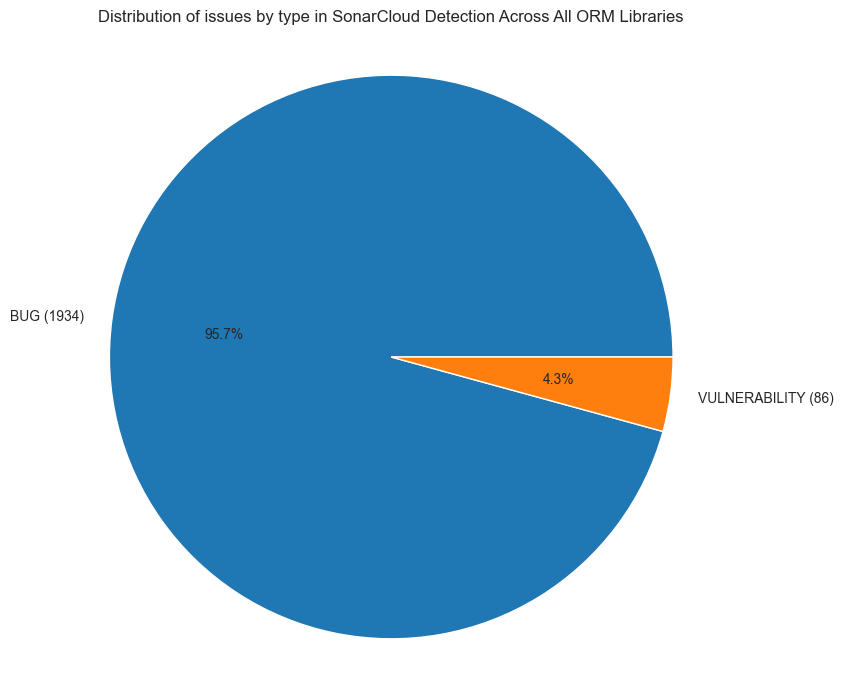

In [26]:
import matplotlib.pyplot as plt

csv_paths = [
    "sonarcloud_data/sonarcloud_ebean.csv",
    "sonarcloud_data/sonarcloud_hibernate-orm.csv",
    "sonarcloud_data/sonarcloud_openjpa.csv",
    "sonarcloud_data/sonarcloud_ponyorm.csv",
    "sonarcloud_data/sonarcloud_sqlalchemy.csv"
]

ebean_df = pd.read_csv(csv_paths[0])
ebean_df['package'] = 'ebean'
hibernate_df = pd.read_csv(csv_paths[1])
hibernate_df['package'] = 'hibernate'
openjpa_df = pd.read_csv(csv_paths[2])
openjpa_df['package'] = 'openjpa'
ponyorm_df = pd.read_csv(csv_paths[3])
ponyorm_df['package'] = 'ponyorm'
sqlalchemy_df = pd.read_csv(csv_paths[4])
sqlalchemy_df['package'] = 'sqlalchemy'

sonarcloud_df = pd.concat([ebean_df, hibernate_df, openjpa_df, openjpa_df, ponyorm_df, sqlalchemy_df], ignore_index=True)
sonarcloud_df = sonarcloud_df[['package','file_path','line_number','type','severity','description']]
sonarcloud_df.to_csv('sonarcloud_data/sonarcloud_results.csv', index=False)

sonarcloud_type_proportion = sonarcloud_df['type'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sonarcloud_type_proportion, labels=[f"{index} ({sonarcloud_type_proportion[index]})" for index in sonarcloud_type_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of issues by type in SonarCloud Detection Across All ORM Libraries', pad=20)
plt.axis('equal')
plt.savefig("plots/sonar_issue_type_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

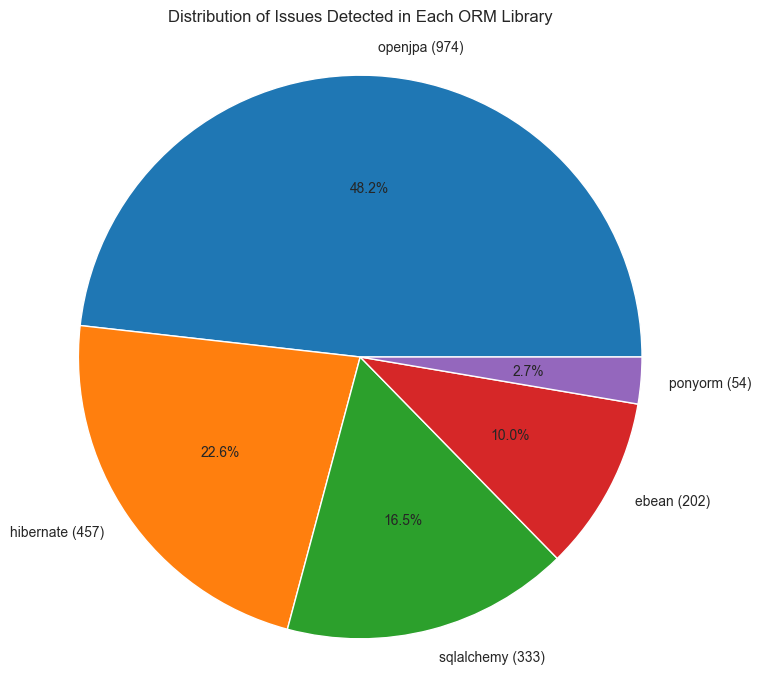

In [27]:
sonarcloud_package_proportion = sonarcloud_df['package'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sonarcloud_package_proportion, labels=[f"{index} ({sonarcloud_package_proportion[index]})" for index in sonarcloud_package_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of Issues Detected in Each ORM Library', pad=20)
plt.axis('equal')
plt.savefig("plots/sonar_issues_by_orm.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [28]:
sonarcloud_sample = sonarcloud_df.sample(n=24, random_state=42)
reviewer_name = ['Hashir Jamil'] * 12 + ['Zachary Ross'] * 12
sonarcloud_sample.insert(0, 'reviewer', reviewer_name)
sonarcloud_sample.to_csv('sonarcloud_data/sonarcloud_sample.csv', index=False)

In [40]:
file_path_frequency_df = sonarcloud_df.groupby(['package','file_path']).size().reset_index(name='file_frequency')
file_path_frequency_df.sort_values(by=['file_frequency'], ascending=False, inplace=True)
file_path_frequency_df.reset_index(drop=True, inplace=True)
file_path_frequency_df.to_csv('sonarcloud_data/sonarcloud_file_frequency.csv', index=False)
file_path_frequency_df

,package,file_path,file_frequency
0,sqlalchemy,test/perf/compiled_extensions.py,56
1,openjpa,openjpa-kernel/src/main/java/org/apache/openjp...,46
2,ebean,ebean-core/src/main/java/io/ebeaninternal/serv...,44
3,sqlalchemy,test/sql/test_operators.py,38
4,hibernate,hibernate-core/src/main/java/org/hibernate/eng...,29
...,...,...,...
647,hibernate,hibernate-core/src/main/java/org/hibernate/pro...,1
648,hibernate,hibernate-core/src/main/java/org/hibernate/per...,1
649,hibernate,hibernate-core/src/main/java/org/hibernate/per...,1
650,hibernate,hibernate-core/src/main/java/org/hibernate/per...,1


In [60]:
subsystem_frequency_df = sonarcloud_df[[ 'package','file_path']].copy()

def modify_file_path(row):
    split_path = row['file_path'].split('/')
    if row['package'] == 'sqlalchemy':
        if len(split_path) <= 3:
            return '/'.join(split_path[:2])
        else:
            return '/'.join(split_path[:3])
    elif row['package'] == 'ponyorm':
        if len(split_path) <= 3:
            return '/'.join(split_path[:2])
        else:
            return '/'.join(split_path[:3])
    else:
        return split_path[0]

subsystem_frequency_df['file_path'] = subsystem_frequency_df.apply(modify_file_path, axis=1)
subsystem_frequency_df = subsystem_frequency_df.groupby(['package','file_path']).size().reset_index(name='subsystem_frequency')
subsystem_frequency_df.sort_values(by=['subsystem_frequency'], ascending=False, inplace=True)
subsystem_frequency_df.reset_index(drop=True, inplace=True)
subsystem_frequency_df.sort_values(['package']).to_csv('sonarcloud_data/sonarcloud_subsystem_frequency.csv', index=False)
subsystem_frequency_df

,package,file_path,subsystem_frequency
0,hibernate,hibernate-core,377
1,openjpa,openjpa-kernel,340
2,openjpa,openjpa-jdbc,232
3,openjpa,openjpa-persistence,158
4,ebean,ebean-core,149
...,...,...,...
59,ponyorm,pony/utils,1
60,ponyorm,pony/thirdparty,1
61,ebean,tests,1
62,ponyorm,pony/orm/dbproviders,1


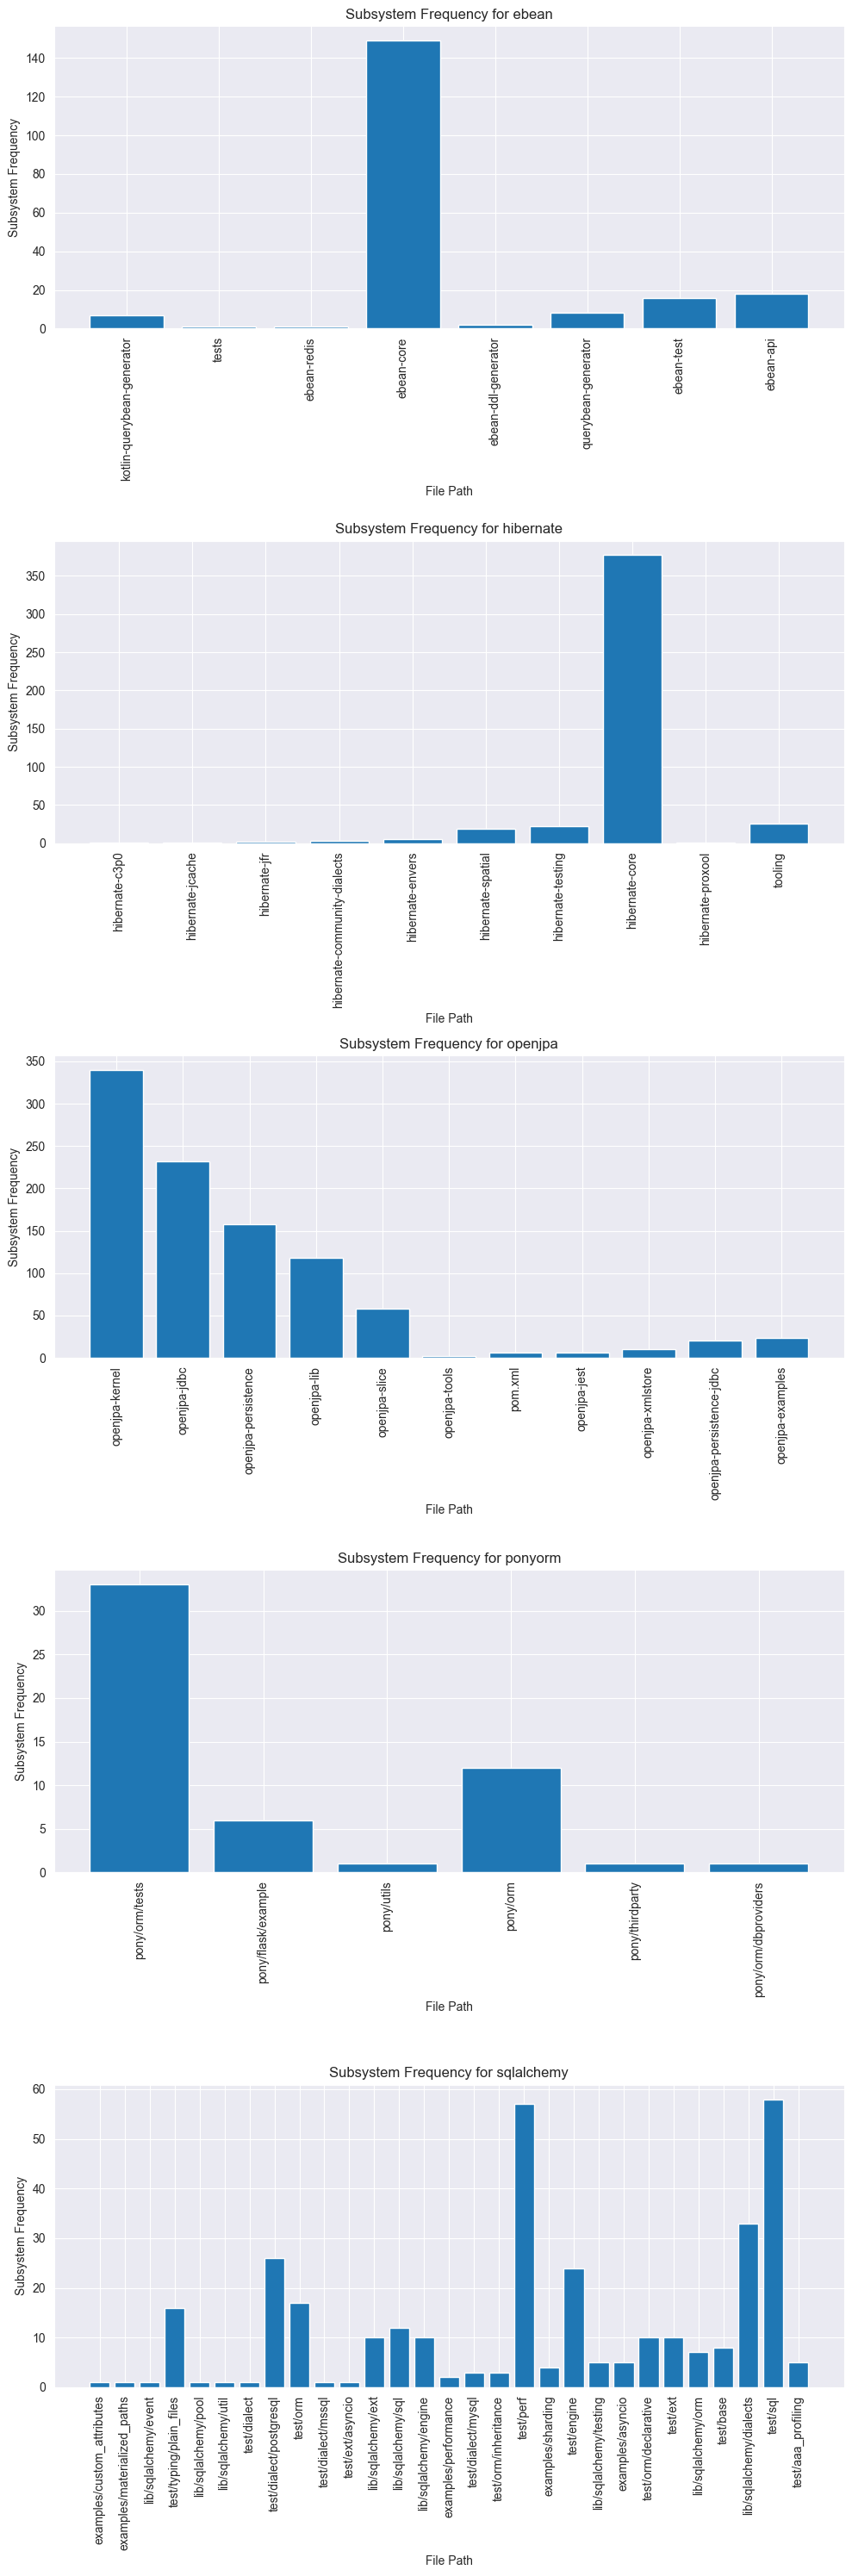

In [62]:
data = pd.read_csv('sonarcloud_data/sonarcloud_subsystem_frequency.csv')

# Group data by package
grouped_data = data.groupby('package')

# Define the number of packages and set up subplots
num_packages = len(grouped_data)
fig, axs = plt.subplots(num_packages, figsize=(10, 6*num_packages))

# Plot for each package
for i, (package, group) in enumerate(grouped_data):
    # Create a subplot for each package
    ax = axs[i] if num_packages > 1 else axs

    # Plot the data for the current package
    ax.bar(group['file_path'], group['subsystem_frequency'])

    # Set labels and title for the subplot
    ax.set_xlabel('File Path')
    ax.set_ylabel('Subsystem Frequency')
    ax.set_title(f'Subsystem Frequency for {package}')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()